# 2. Inspect and organize S1-RTC data processed by ASF

Now that we have read in and organized the stack of Sentinel-1 RTC images, this notebook will demonstrate preliminary dataset inspection. 

## Learning goals

**Techniques:**

- Comparing raster images
- Using `xr.groupby()` for [grouped statistics](https://docs.xarray.dev/en/stable/user-guide/groupby.html)
- Simple raster calculations
- Indexing and selection
- Visualizing multiple facets of the data using `FacetGrid`
- Reorganizing data with `xr.Dataset.reindex()`

**Science concepts:**

- Dataset inspection and evaluation

### Other useful resources
These are resources that contain additional examples and discussion of the content in this notebook and more.
- [Xarray user guide](https://docs.xarray.dev/en/stable/user-guide/index.html)
- [How do I...](https://docs.xarray.dev/en/stable/howdoi.html) this is **very** helpful!
- [Xarray High-level computational patterns](https://tutorial.xarray.dev/intermediate/01-high-level-computation-patterns.html) discussion of concepts and associated code examples
- [Parallel computing with dask](https://tutorial.xarray.dev/intermediate/xarray_and_dask.html) Xarray tutorial demonstrating wrapping of dask arrays

### ASF Data Access

You can download the RTC-processed backscatter time series [here](https://zenodo.org/record/7236413#.Y1rNi37MJ-0)

## Software and setup

In [2]:
%xmode minimal
import os
import xarray as xr
import rioxarray as rio
import geopandas as gpd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import dask

from pathlib import Path

import s1_tools

import warnings

warnings.filterwarnings("ignore", category=UserWarning)

Exception reporting mode: Minimal


### Read in prepared data

First, we'll use cell magic to read in the object we prepared in the first notebook:

In [3]:
s1_cube = xr.open_dataset(
    "../data/tutorial2/s1_asf_cube.zarr", engine="zarr"
)  # engine arg for zarr2.8

In [4]:
s1_cube

<xarray.Dataset> Size: 284MB
Dimensions:                           (acq_date: 103, y: 396, x: 290)
Coordinates: (12/21)
  * acq_date                          (acq_date) datetime64[ns] 824B 2021-05-...
    area_or_clipped                   (acq_date) <U1 412B ...
    beam_mode                         (acq_date) <U2 824B ...
    deadreckoning_or_demmatch         (acq_date) <U1 412B ...
    granule_id                        (acq_date) <U67 28kB ...
    notfiltered_or_filtered           (acq_date) <U1 412B ...
    ...                                ...
    sensor                            (acq_date) <U3 1kB ...
    spatial_ref                       int64 8B ...
    terrain_correction_pixel_spacing  (acq_date) <U5 2kB ...
    unmasked_or_watermasked           (acq_date) <U1 412B ...
  * x                                 (x) float64 2kB 6.194e+05 ... 6.281e+05
  * y                                 (y) float64 3kB 3.102e+06 ... 3.09e+06
Data variables:
    ls                                (acq_date, y, x) float64 95MB ...
    vh                                (acq_date, y, x) float64 95MB ...
    vv                                (acq_date, y, x) float64 95MB ...

In [5]:
def plot_timestep(input_arr, time_step_int):
    """plots VV and VH polarizations of a given dataset at a given time step"""
    date = input_arr.isel(acq_date=time_step_int).acq_date.dt.date.data
    fig, axs = plt.subplots(ncols=3, figsize=(24, 7))

    input_arr.isel(acq_date=time_step_int).ls.plot(ax=axs[0])
    s1_tools.power_to_db(input_arr.isel(acq_date=time_step_int).vv).plot(
        ax=axs[1], cmap=plt.cm.Greys_r
    )
    s1_tools.power_to_db(input_arr.isel(acq_date=time_step_int).vh).plot(
        ax=axs[2], cmap=plt.cm.Greys_r
    )
    fig.suptitle(
        f"Layover-shadow mask (L), VV (C) and VH (R) backscatter {str(input_arr.isel(acq_date=time_step_int).acq_date.data)[:-19]}"
    )
    axs[0].set_title(f"{date} layover-shadow map")
    axs[1].set_title(f"{date} VV backscatter")
    axs[2].set_title(f"{date} VH backscatter")

## Layover-shadow mask

Each RTC image comes with a geotiff file containing a layover-shadow mask. This can help to understand missing data you might see in the imagery files. The layover shadow masks are coded to represent a number of different types of pixels:

The following information is copied from the README file that accompanies each scene: 

```{**Layover-shadow mask**}

The layover/shadow mask indicates which pixels in the RTC image have been affected by layover and shadow. This layer is tagged with _ls_map.tif

The pixel values are generated by adding the following values together to indicate which layover and shadow effects are impacting each pixel:
0.  Pixel not tested for layover or shadow
1.  Pixel tested for layover or shadow
2.  Pixel has a look angle less than the slope angle
4.  Pixel is in an area affected by layover
8.  Pixel has a look angle less than the opposite of the slope angle
16. Pixel is in an area affected by shadow

There are 17 possible different pixel values, indicating the layover, shadow, and slope conditions present added together for any given pixel._

The values in each cell can range from 0 to 31:
0.  Not tested for layover or shadow
1.  Not affected by either layover or shadow
3.  Look angle < slope angle
5.  Affected by layover
7.  Affected by layover; look angle < slope angle
9.  Look angle < opposite slope angle
11. Look angle < slope and opposite slope angle
13. Affected by layover; look angle < opposite slope angle
15. Affected by layover; look angle < slope and opposite slope angle
17. Affected by shadow
19. Affected by shadow; look angle < slope angle
21. Affected by layover and shadow
23. Affected by layover and shadow; look angle < slope angle
25. Affected by shadow; look angle < opposite slope angle
27. Affected by shadow; look angle < slope and opposite slope angle
29. Affected by shadow and layover; look angle < opposite slope angle
31. Affected by shadow and layover; look angle < slope and opposite slope angle

```

The ASF RTC image [product guide](https://hyp3-docs.asf.alaska.edu/guides/rtc_product_guide/) has detailed descriptions of how the data is processed and what is included in the processed dataset.

### Quick visualization

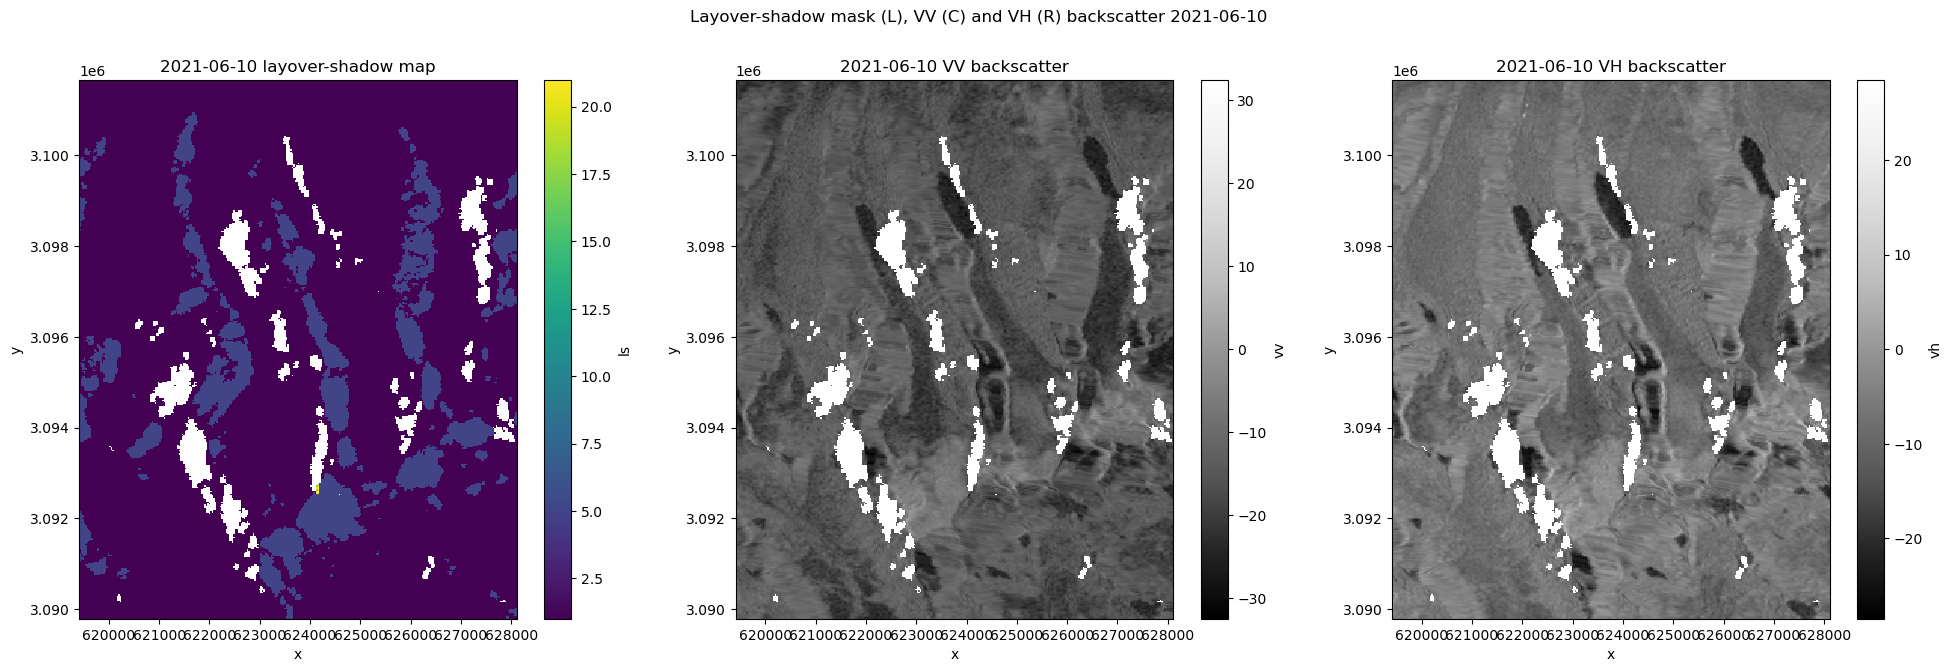

In [6]:
plot_timestep(s1_cube, 11)

In [7]:
cmap1 = plt.colormaps["gist_ncar"].resampled(20)

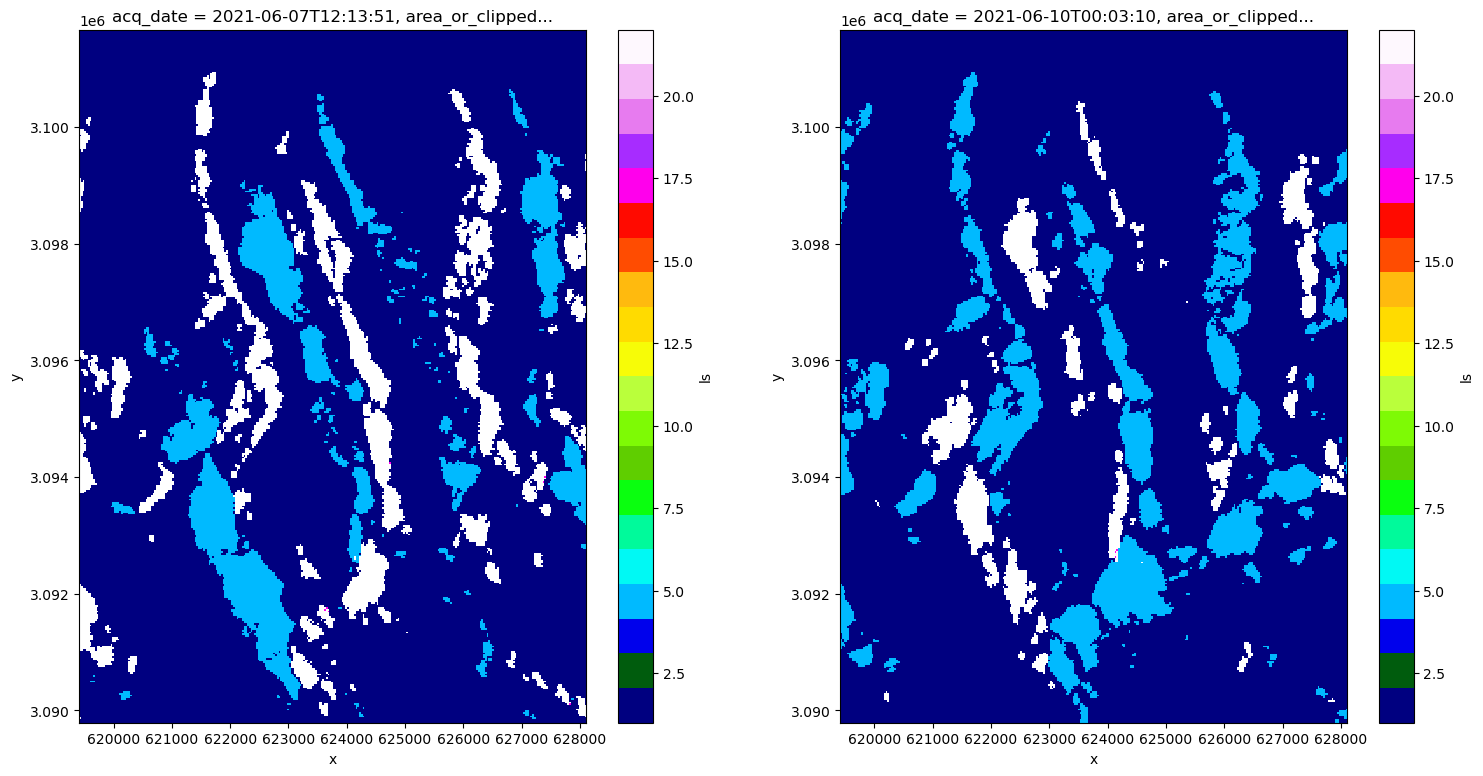

In [8]:
fig, axs = plt.subplots(ncols=2, figsize=(18, 9))

s1_cube.isel(acq_date=10).ls.plot(ax=axs[0], vmax=22, vmin=1, cmap=cmap1)
s1_cube.isel(acq_date=11).ls.plot(ax=axs[1], vmax=22, vmin=1, cmap=cmap1);

It looks like there are areas affected by different types of distortion on different dates. For example, in the lower left quadrant, there is a region that is blue (5 - affected by layover) on 6/7/2021 but much of that area appears to be in radar shadow on 6/10/2021. This pattern is present throughout much of the scene with portions of area that are affected by layover in one acquisition in shadow in the next acquisition. This is due to different viewing geometries on different orbital passes: one of the above scenes was likely collected during an ascending pass and one during a descending.

Thanks to all the setup work we did in the previous notebook, we can confirm that: 

In [9]:
s1_cube.isel(acq_date=10).orbital_dir.values

array('desc', dtype='<U4')

In [10]:
s1_cube.isel(acq_date=11).orbital_dir.values

array('asc', dtype='<U3')

## Looking at backscatter variability

Let's look at how VV and VH backscatter vary over time. 

In [11]:
vrt_vv = s1_cube["vv"]
vrt_vh = s1_cube["vh"]

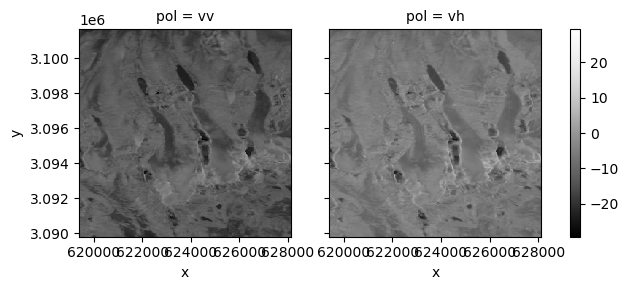

In [12]:
mean_pol = xr.Dataset({"vv": vrt_vv.mean("acq_date"), "vh": vrt_vh.mean("acq_date")})
s1_tools.power_to_db(mean_pol).to_array("pol").plot(col="pol", cmap=plt.cm.Greys_r);

Now let's look at how backscatter may vary seasonally for a single polarization (for more on time-related GroupBy operations see the [Xarray User Guide](https://docs.xarray.dev/en/stable/user-guide/time-series.html#resampling-and-grouped-operations).

In [13]:
vrt_gb = s1_cube.groupby("acq_date.season").mean()

In [14]:
vrt_gb

<xarray.Dataset> Size: 11MB
Dimensions:      (season: 4, y: 396, x: 290)
Coordinates:
    spatial_ref  int64 8B 0
  * x            (x) float64 2kB 6.194e+05 6.195e+05 ... 6.281e+05 6.281e+05
  * y            (y) float64 3kB 3.102e+06 3.102e+06 ... 3.09e+06 3.09e+06
  * season       (season) object 32B 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    ls           (season, y, x) float64 4MB 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    vh           (season, y, x) float64 4MB 0.1108 0.1239 ... 0.2862 0.2956
    vv           (season, y, x) float64 4MB 0.02098 0.0221 ... 0.04669 0.04661

In [15]:
# order seasons correctly
vrt_gb = vrt_gb.reindex({"season": ["DJF", "MAM", "JJA", "SON"]})
vrt_gb

<xarray.Dataset> Size: 11MB
Dimensions:      (x: 290, y: 396, season: 4)
Coordinates:
  * x            (x) float64 2kB 6.194e+05 6.195e+05 ... 6.281e+05 6.281e+05
  * y            (y) float64 3kB 3.102e+06 3.102e+06 ... 3.09e+06 3.09e+06
  * season       (season) <U3 48B 'DJF' 'MAM' 'JJA' 'SON'
    spatial_ref  int64 8B 0
Data variables:
    ls           (season, y, x) float64 4MB 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    vh           (season, y, x) float64 4MB 0.1108 0.1239 ... 0.2862 0.2956
    vv           (season, y, x) float64 4MB 0.02098 0.0221 ... 0.04669 0.04661

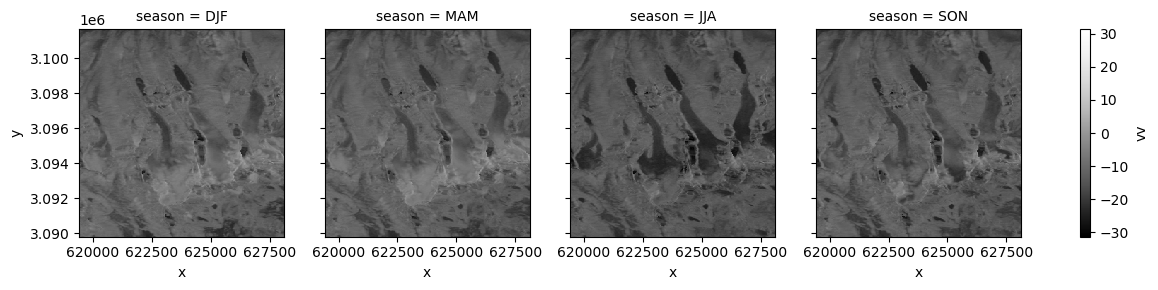

In [16]:
fg_ = s1_tools.power_to_db(vrt_gb.vv).plot(col="season", cmap=plt.cm.Greys_r);

Interesting, it looks like the winter and spring composites are relatively similar to one another. There also appears to be a decrease in backscatter moving from spring to summer. 

## Handling duplicate time steps

If we take a closer look at the ASF dataset, we can see that there are a few scenes from identical acquisitions (can see this in `acq_date` and more specifically in `product_id`. Let's examine these and see what's going on, if we want to keep the duplicates: 

First we'll extract the data_date_id from the Sentinel-1 granule ID: 

In [17]:
data_take_asf = [
    str(s1_cube.isel(acq_date=t).granule_id.values)[56:62]
    for t in range(len(s1_cube.acq_date))
]

Then assign it as a non-dimensional coordinate: 

In [18]:
s1_cube.coords["data_take_id"] = (
    "acq_date",
    data_take_asf,
    {"ID of data take from SAR acquisition": "ID data take"},
)

In [19]:
asf_ids = list(s1_cube.data_take_id.values)

In [20]:
len(asf_ids)

103

The length of the `asf_ids` list is exactly what we'd expect, 103. Let's look at the number of unique elements using [`np.unique()`](https://numpy.org/doc/stable/reference/generated/numpy.unique.html).

In [21]:
asf_set = np.unique(s1_cube.data_take_id.data)

In [22]:
len(asf_set)

96

Interesting - it looks like there are only 96 unique elements when we look at the `data_take_id`. Let's figure out which are duplicates:

In [23]:
def duplicate(input_ls):
    return list(set([x for x in input_ls if input_ls.count(x) > 1]))

In [24]:
duplicate_ls = duplicate(asf_ids)
duplicate_ls

['0492D4', '047898', '05154A', '052C00', '048D87']

These are the data take IDs that are duplicated in the dataset. We now want to subset the xarray object to only include these data take IDs: 

In [25]:
asf_duplicate_cond = s1_cube.data_take_id.isin(duplicate_ls)
asf_duplicate_cond

<xarray.DataArray 'data_take_id' (acq_date: 103)> Size: 103B
array([False, False, False,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
       False, False,  True,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False,  True,  True,  True])
Coordinates: (12/20)
  * acq_date                          (acq_date) datetime64[ns] 824B 2021-05-...
    area_or_clipped                   (acq_date) <U1 412B 'e' 'e' ... 'e' 'e'
    beam_mode                         (acq_date) <U2 824B 'IW' 'IW' ... 'IW'
    deadreckoning_or_demmatch         (acq_date) <U1 412B 'd' 'd' ... 'd' 'd'
    granule_id                        (acq_date) <U67 28kB 'S1A_IW_SLC__1SDV_...
    notfiltered_or_filtered           (acq_date) <U1 412B 'n' 'n' ... 'n' 'n'
    ...                                ...
    product_id                        (acq_date) <U4 2kB '3C39' ... '5844'
    sensor                            (acq_date) <U3 1kB 'S1A' 'S1A' ... 'S1A'
    spatial_ref                       int64 8B 0
    terrain_correction_pixel_spacing  (acq_date) <U5 2kB 'RTC30' ... 'RTC30'
    unmasked_or_watermasked           (acq_date) <U1 412B 'u' 'u' ... 'u' 'u'
    data_take_id                      (acq_date) <U6 2kB '047321' ... '052C00'

In [26]:
asf_duplicates = s1_cube.where(asf_duplicate_cond == True, drop=True)
asf_duplicates

<xarray.Dataset> Size: 33MB
Dimensions:                           (acq_date: 12, y: 396, x: 290)
Coordinates: (12/22)
  * acq_date                          (acq_date) datetime64[ns] 96B 2021-05-1...
    area_or_clipped                   (acq_date) <U1 48B 'e' 'e' 'e' ... 'e' 'e'
    beam_mode                         (acq_date) <U2 96B 'IW' 'IW' ... 'IW' 'IW'
    deadreckoning_or_demmatch         (acq_date) <U1 48B 'd' 'd' 'd' ... 'd' 'd'
    granule_id                        (acq_date) <U67 3kB 'S1A_IW_SLC__1SDV_2...
    notfiltered_or_filtered           (acq_date) <U1 48B 'n' 'n' 'n' ... 'n' 'n'
    ...                                ...
    spatial_ref                       int64 8B 0
    terrain_correction_pixel_spacing  (acq_date) <U5 240B 'RTC30' ... 'RTC30'
    unmasked_or_watermasked           (acq_date) <U1 48B 'u' 'u' 'u' ... 'u' 'u'
  * x                                 (x) float64 2kB 6.194e+05 ... 6.281e+05
  * y                                 (y) float64 3kB 3.102e+06 ... 3.09e+06
    data_take_id                      (acq_date) <U6 288B '047898' ... '052C00'
Data variables:
    ls                                (acq_date, y, x) float64 11MB 1.0 ... nan
    vh                                (acq_date, y, x) float64 11MB 0.1432 .....
    vv                                (acq_date, y, x) float64 11MB 0.01493 ....

Great, now we have a 12-time step xarray object that contains only the duplicate data takes. Let's see what it looks like. We can use `xr.FacetGrid` objects to plot these all at once: 

In [27]:
fg = asf_duplicates.vv.plot(col="acq_date", col_wrap=4)

ValueError: Coordinates used for faceting cannot contain repeated (nonunique) values.

Oops, we can't use faceting along the `acq_date` dimension here because of the repeated time steps that we want to look at. Xarray does not know how to handle these repeated values when it is creating the small multiples.

For now we'll ignore the repeated values to visualize what's present

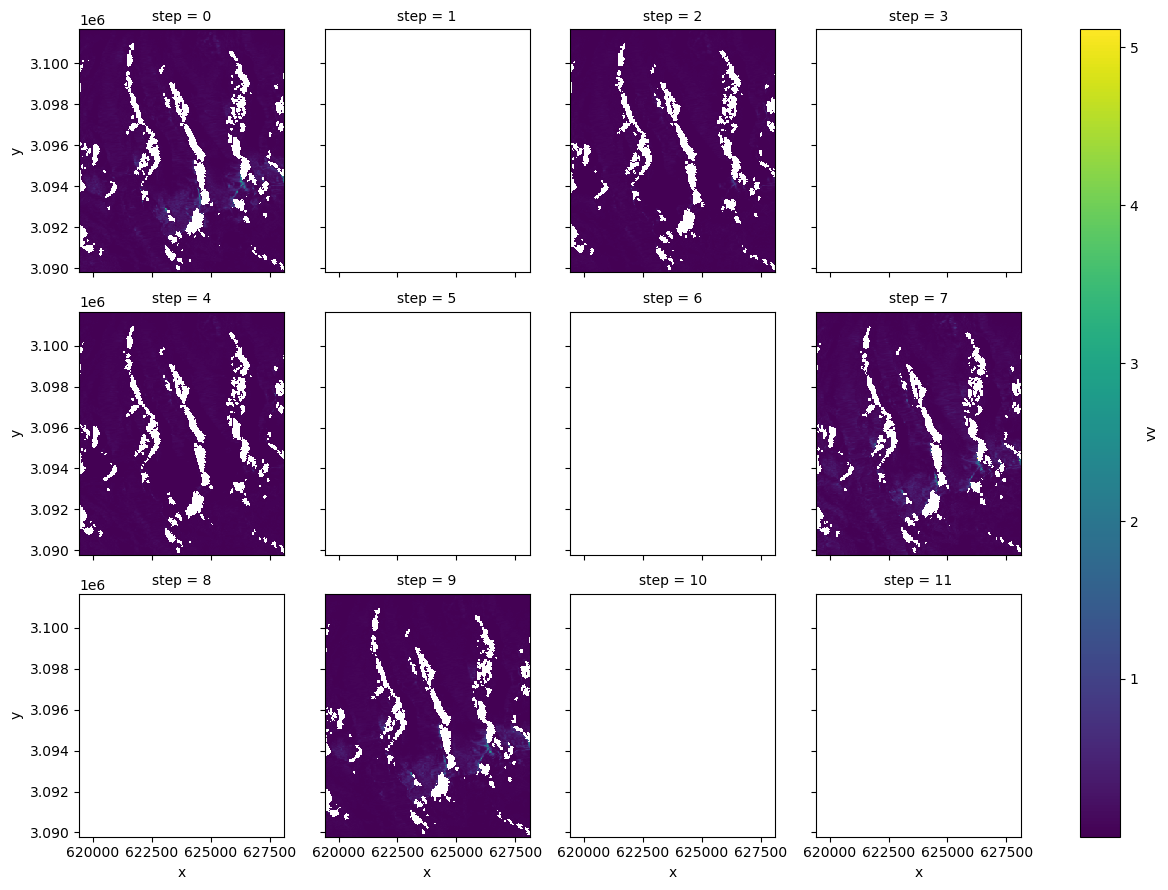

In [29]:
fg = asf_duplicates.rename_dims({"acq_date": "step"}).vv.plot(col="step", col_wrap=4)

Interesting, it looks like there's only really data for the 0, 2, 4, 7 and 9 elements of the list of duplicates.

To drop these, we need to extract the product ID of each duplicate we'd like to remove, since this is the only variable that is unique among the duplicates.

In [30]:
drop_ls = [1, 3, 5, 6, 8, 10, 11]

We can use xarray's `.isel()` method, `.xr.DataArray.isin()`, `xr.Dataset.where()`, and list comprehension to efficiently subset the time steps we want to keep: 

In [31]:
drop_product_id_ls = asf_duplicates.isel(acq_date=drop_ls).product_id.data

In [32]:
drop_product_id_ls

array(['5569', '1424', '3770', '8F7B', '748F', '0031', '5844'],
      dtype='<U4')

Using this list, we want to drop all of the elements of `vrt_full` where product Id is one of the values in the list.

In [33]:
duplicate_cond = ~s1_cube.product_id.isin(drop_product_id_ls)

In [34]:
vrt_new = s1_cube.where(duplicate_cond == True, drop=True)

In [ ]:
vrt_new["output_unit"]

NameError: name 'vrt_new' is not defined

Now we will store the updated version of vrt_full (`vrt_new`) to use in later notebooks:

In [36]:
vrt_new.to_zarr("../data/tutorial2/s1_asf_cube_updated.zarr", mode="w")

## Wrap up 

This notebook gives a brief look in to the vast amount of auxiliary data that is contained within this dataset. Making the most and best use of this dataset requires familiarity with the the many different types of information it includes. 